In [68]:
import numpy as np
import matplotlib.pyplot as plt
from DAmethod.EnKF import EnKF
from dynamicalsystems.anharmonic_oscillator import NonLinearOscillatorModel
%matplotlib inline

In [69]:
H = np.atleast_2d([0, 1])
R = np.atleast_2d([49])
state_dimension = 2
period_assim = 50
Nensemble = 32
assimilation_steps=200
inflation_factor = 1.

initial_state = np.array([0, 1])
#46900

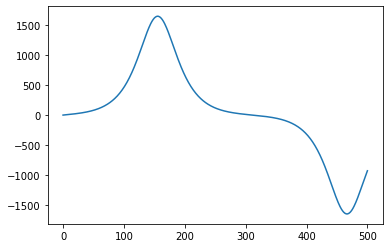

In [70]:
# Reference model
NonLinearOscillatorModel.xi = [0]
truth = NonLinearOscillatorModel()

truth.set_initial_state(0, initial_state)
truth.forward(500)
plt.plot(truth.state_vector[0, :])

def generate_observations(i):
    truth.forward(period_assim)
    y = truth.state_vector[:, -1] + np.random.randn(1) * np.sqrt(float(R))
    return truth.t[-1], y

# Reset to initial state
truth.set_initial_state(0, initial_state, force_reset=True)

In [71]:
enkf = EnKF(state_dimension, Nensemble, R, inflation_factor)
enkf.set_forwardmodel(lambda x: NonLinearOscillatorModel.integrate(0, x, period_assim,)[1][:, -1])
enkf.H = H

In [72]:
siginit = .05
covariance = siginit * np.eye(2)
enkf.generate_ensemble(mean=initial_state, cov=covariance)

In [73]:
dEnKF = enkf.run(assimilation_steps, get_obs=generate_observations)

In [74]:
t = np.asarray(dEnKF['time'])
xf = np.asarray(dEnKF['ensemble_f'])
xfbar = xf.mean(2)
xa = np.asarray(dEnKF['ensemble_a'])
xabar = xa.mean(2)
obs = np.asarray(dEnKF['observations'])
print(f"{t.shape=}\n{xf.shape=}\n{xa.shape=}\n{obs.shape=}")

t.shape=(200,)
xf.shape=(200, 2, 64)
xa.shape=(200, 2, 64)
obs.shape=(200, 2)


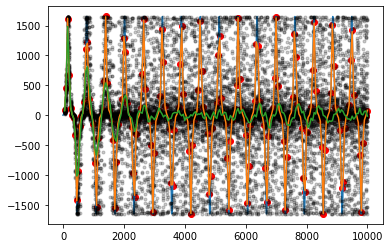

In [75]:
plt.plot(t, obs[:, 0], 'or')
plt.plot(truth.t, truth.state_vector[0, :])
plt.plot(t, xf[:, 0, :], '.', color='black', alpha=0.2)
plt.plot(t, xabar[:, 0])
plt.plot(t, xfbar[:, 0])

In [76]:
analysis_error = xabar[:, 0] - truth.state_vector[0, period_assim::period_assim]


In [77]:
(analysis_error**2).sum()

47579.11126894779